# **Septin Detection** Notebook for QFM2025 Course

This notebook provides a workflow for **detecting septin rings in microscopy images**. It includes steps for dataset preparation, model training, and prediction using YOLOv8, with customizable options to fine-tune the detection process. Designed specifically for the **QFM2025 course**, it aims to make object detection in pSTORM data.

contact: amin.zehtabian@fu-berlin.de
Last Update: Jan 2025

###GPU Check + Installing necessary libraries


Execute this cell to verify **GPU** access and install some necessary **libraries**.

Note: To use a better GPU, go to the toolbar, select **Runtime**, and switch the Runtime Type to one of the available GPU options

In [2]:
!nvidia-smi
from matplotlib import image
from matplotlib import pyplot as plt
from PIL import Image
#from IPython import display
#display.clear_output()
#from IPython.display import display, Image
import glob
import random
import os
!pip install tqdm   # for progress bar
from tqdm.notebook import tqdm
HOME = os.getcwd();
#display(HOME)


Wed Jan 29 14:49:25 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   36C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Optional: Mount **Google Drive** and get the current working directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#@markdown ###Path to the project (where the data and final models should be stored):
project_path = '/content/Project_Septin'#@param {type:"string"}

import os
#%cd project_path
!mkdir {project_path}
os.chdir(project_path)
HOME = os.getcwd()

# Installing YOLOv8

We are now ready to use the YOLOv8 model for training on our annotated images. **YOLOv8** supports a variety of prediction tasks, including:

- **Detection**: Drawing bounding boxes around objects.
- **Segmentation**: Outlining objects in an image.
- **Tracking**: Following objects across frames in a video.
- **Image Classification**: Categorizing images into predefined classes.
- **Pose Detection**: Estimating keypoints for human or object poses.

For our project, the focus will be on the **Detection of Septin Rings** (and later, Segmentation of rings). You can find examples and additional resources on the Ultralytics GitHub page ((https://github.com/ultralytics/ultralytics))

In [5]:
%pip install ultralytics --quiet
import ultralytics
ultralytics.checks()

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 31.3/235.7 GB disk)


# Calling YOLO
Next, we'll import YOLO as well as a few handy libraries for later use.

In [4]:
from ultralytics import YOLO

# Run Standard Pre-Trained YOLO Models on the Test Image

- Create a sub-folder named 'test' within your project folder (default: 'Project_Septin/test/').
- Place example test images into this folder.
- This cell runs a standard pre-trained YOLOv8 model on the test images. However, since the model has not been trained on data similar to your septin images, you will observe that no detection or segmentation is performed on these images.

/content

image 1/1 /content/Project_Septin/test/test.jpg: 640x640 (no detections), 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Project_Septin/test/test.jpg: 640x640 (no detections), 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


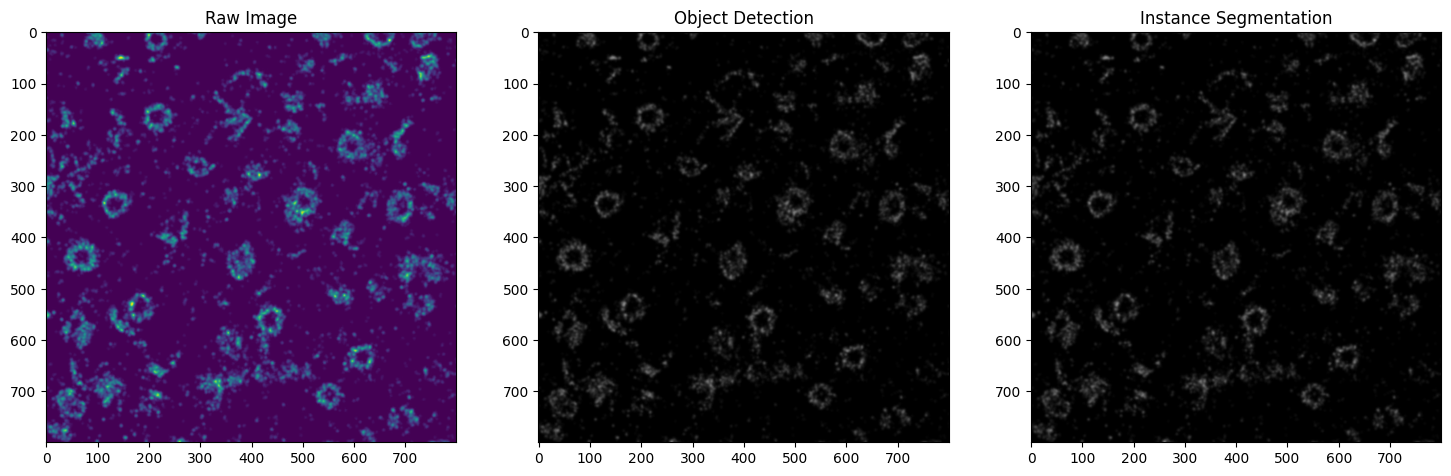

In [11]:
from ultralytics import YOLO

#%cd {HOME}/test
Test_Image1 = '/content/Project_Septin/test/test.jpg'
#plt.imshow(image.imread(Test_Image1))

%cd {HOME}
# Standard pre-trained model for detection
model_detection = YOLO('yolov8n.pt')
# Standard pre-trained model for segmentation
model_segmentation = YOLO('yolov8n-seg.pt')

# Run the standard pre-trained models for detection and segmentation
prediction_detection = model_detection.predict(Test_Image1)
prediction_segmentation = model_segmentation.predict(Test_Image1)
# Visualization
detection_result_array = prediction_detection[0].plot()
instance_result_array = prediction_segmentation[0].plot()


fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Raw Image")
plt.imshow(image.imread(Test_Image1))
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Object Detection")
ax2.imshow(detection_result_array)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title("Instance Segmentation")
ax3.imshow(instance_result_array)

# Training → Step #1: Importing the Training Dataset from Roboflow

To enable the model to recognize microscopy images containing septin rings, we need to train the model further (also known as **fine-tuning**) using a suitable training dataset. If you don’t have a pre-existing dataset, you will need to create one and annotate the training images.

There are several tools available for annotating objects in images, and the choice of tool depends on the type of annotation required. For example, annotations for object detection differ from those needed for segmentation. One of the simplest and most effective tools for annotation is **Roboflow** (https://roboflow.com/).

To help you get started, I have prepared a PowerPoint file with detailed instructions on creating training samples. Once you have created a custom training dataset using Roboflow, simply copy and paste your **API_KEY** into the code below to integrate it into your project.

In [12]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets
!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="0o69ClS8r4Cwtju09p6Y")
project = rf.workspace("agewers-30oij").project("test-ykv9r")
version = project.version(1)
dataset = version.download("yolov8")


/content/Project_Septin/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 43.7 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to test-1 in yolov8:: 100%|██████████| 52/52 [00:00<00:00, 7575.15it/s]


# Training → Step #2: Modifying the data.yaml file

The training dataset has been successfully imported from the Roboflow cloud repository.

**Note 1:**
You can access the training, validation, and test images under the folder '**/datasets/**'. Detailed information about the datasets, such as paths and class labels, can be found in the file **data.yaml**.

**Note 2:**
In some versions of YOLOv8, you might encounter an error indicating that the model cannot locate the training and validation folders. To resolve this issue, open the **data.yaml** file and make a small modification. Update the paths to the following training and validation datasets to ensure they are correctly referenced:

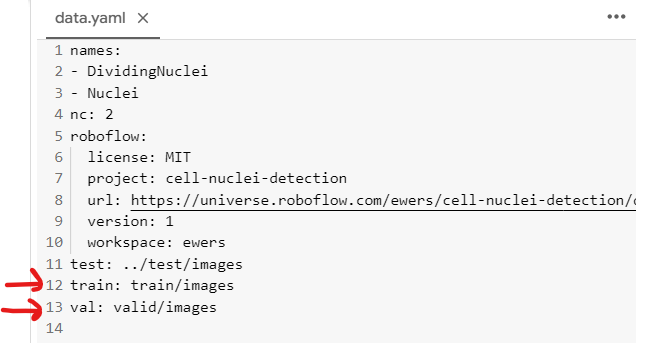

# Training → Step #3: Parameter Setting for Training

Here we need to set some training parameters, including the exact YOLOv8 pre-trained model we are going to fune-tune further.

We may begin training with the **YOLOv8s.pt model**, which is the "small" version of YOLOv8 designed for object detection. This model provides a balance between speed and accuracy, making it suitable for many applications.

Note:
You are welcome to experiment with other YOLOv8 models based on your requirements:

Less complex models:
- YOLOv8n.pt (nano): Prioritizes speed and efficiency, suitable for resource-constrained environments.

More complex models:
- YOLOv8m.pt (medium): Offers improved accuracy at the cost of slightly higher computational requirements.
- YOLOv8l.pt (large): Focuses on higher accuracy and is suitable for high-powered setups.
- YOLOv8x.pt (extra-large): Provides the best accuracy but requires significant computational resources.

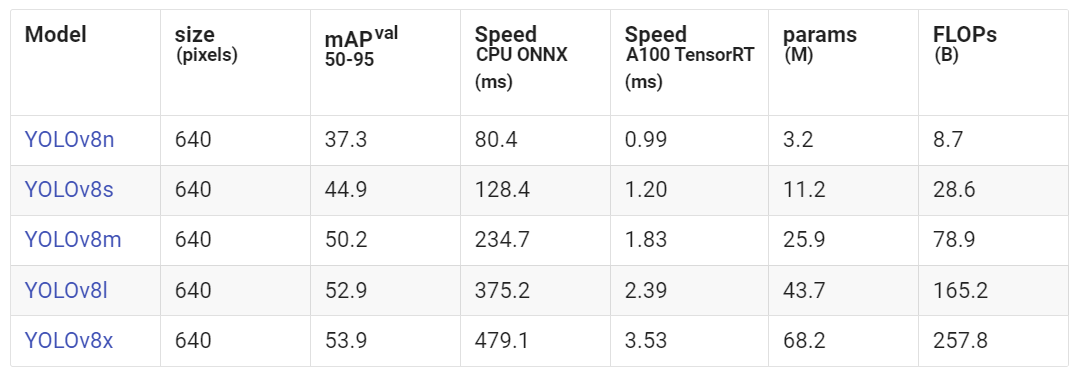

Feel free to play with **training parameters & settings** such as the number of epochs, image size, etc.


In [14]:


#Training_source = base_path + "/data/Stardist/Training - Images" #@param {type:"string"}
#Training_target = base_path + "/data/Stardist/Training - Masks" #@param {type:"string"}

#@markdown ###Name and path to the final trained model:

trained_model_name = "SeptinDetection_Model1_ep50" #@param {type:"string"}

trained_model_path = project_path + "/Models" #@param {type:"string"}
#trained_model = model_path

#project_folder_name = 'CytoYOLOv8_RectLabel' #@param {type:"string"}
#result_folder_name = 'SemiSparse_modelS_ep200_ba8_'#@param {type:"string"}

#@markdown ### Choose between the pretrained YOLO detection models (n, s, m, l , x):
YOLO_model_type= 'm'#@param {type:"string"}
#@markdown ### Other parameters for training:
epochs =  100#@param {type:"number"}
batch_size =  4#@param {type:"number"}
initial_learning_rate = 0.01#@param {type:"number"}
patch_width = 200#@param {type:"number"}
patch_height = 200#@param {type:"number"}
imgsz = (patch_width,patch_height)

# Training → Step #4: Model Training

Finally, it's time for training (fine-tuning) the YOLOv8 on our data!

In [15]:
from ultralytics import YOLO

optimizer = 'auto' # SGD, Adam, AdamW, NAdam, RAdam, RMSProp or auto
plots= True  # Generates and saves plots of training and validation metrics, as well as prediction examples
#model = YOLO('yolov8n.pt')  # load a pretrained YOLO detection model (n, s, m, l , x)
model_pt = 'yolov8'+YOLO_model_type+'.pt'
model = YOLO(model_pt)
#@markdown ###Path to the YAML file
yaml_address = '/content/Project_Septin/datasets/test-1/data.yaml'#@param {type:"string"}
model.train(data=yaml_address, epochs=epochs, batch=batch_size, lr0= initial_learning_rate, imgsz=imgsz, save=True, pretrained=True,optimizer=optimizer, plots = plots)  # train the model

100%|██████████| 49.7M/49.7M [00:00<00:00, 273MB/s]


Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/Project_Septin/datasets/test-1/data.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=(200, 200), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 305MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=200'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
WARNING ⚠️ imgsz=[200] must be multiple of max stride 32, updating to [224]


train: Scanning /content/Project_Septin/datasets/test-1/train/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 1362.97it/s]

train: New cache created: /content/Project_Septin/datasets/test-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Project_Septin/datasets/test-1/valid/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 979.98it/s]

val: New cache created: /content/Project_Septin/datasets/test-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.828G      2.283      3.892      1.197         17        224: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all          4         12     0.0119        0.5     0.0109    0.00479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.648G      2.448      4.057      1.197         21        224: 100%|██████████| 4/4 [00:00<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.08it/s]

                   all          4         12     0.0135      0.583     0.0127    0.00602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.648G      2.245      4.101      1.157         21        224: 100%|██████████| 4/4 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.07it/s]

                   all          4         12     0.0138      0.583     0.0131    0.00654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.648G      2.611      4.059      1.205         23        224: 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.24it/s]

                   all          4         12     0.0134      0.583     0.0141    0.00713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.795G      2.307       4.32      1.119         10        224: 100%|██████████| 4/4 [00:00<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.33it/s]

                   all          4         12      0.443      0.833      0.664      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.858G      1.945       4.43       1.06         16        224: 100%|██████████| 4/4 [00:00<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.07it/s]

                   all          4         12     0.0198      0.167     0.0106    0.00555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.858G      1.901      4.118     0.9624         11        224: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.75it/s]

                   all          4         12     0.0198      0.167     0.0106    0.00555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.858G      2.116      2.829      1.026         25        224: 100%|██████████| 4/4 [00:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.30it/s]

                   all          4         12    0.00978      0.333    0.00658    0.00356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.847G      2.093      2.196      1.021         12        224: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.02it/s]

                   all          4         12      0.087      0.667     0.0785     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.858G      2.143       2.91      1.025         20        224: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]

                   all          4         12      0.087      0.667     0.0785     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.858G      1.859       2.59      1.048         16        224: 100%|██████████| 4/4 [00:00<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.58it/s]

                   all          4         12       0.04      0.917     0.0404     0.0181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.858G      1.758      2.153     0.9846         10        224: 100%|██████████| 4/4 [00:00<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.94it/s]

                   all          4         12       0.04      0.917     0.0404     0.0181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.858G      2.326      2.063      1.043         16        224: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.19it/s]

                   all          4         12      0.272      0.583      0.221      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.858G      2.029      1.528      1.044         21        224: 100%|██████████| 4/4 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.59it/s]

                   all          4         12      0.272      0.583      0.221      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.864G      1.992      1.608      1.048         17        224: 100%|██████████| 4/4 [00:00<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.24it/s]

                   all          4         12      0.431      0.667      0.681      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.864G      1.723      1.738     0.9265         26        224: 100%|██████████| 4/4 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.68it/s]

                   all          4         12      0.431      0.667      0.681      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.864G      1.719       1.45     0.9686         16        224: 100%|██████████| 4/4 [00:00<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.53it/s]

                   all          4         12      0.431      0.667      0.681      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.864G      1.745      1.901       0.96         31        224: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.65it/s]

                   all          4         12      0.969      0.667      0.777      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.864G       1.76      1.516     0.9784         18        224: 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.75it/s]

                   all          4         12      0.969      0.667      0.777      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.864G      1.896      1.479      1.002         11        224: 100%|██████████| 4/4 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.70it/s]

                   all          4         12      0.969      0.667      0.777      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.864G      1.698      1.554     0.9716         14        224: 100%|██████████| 4/4 [00:00<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.46it/s]

                   all          4         12      0.969      0.667      0.777      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.864G      1.889      1.557      1.023          7        224: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.70it/s]

                   all          4         12      0.467       0.75      0.508      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.864G      1.964      1.415      1.024          3        224: 100%|██████████| 4/4 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.94it/s]

                   all          4         12      0.467       0.75      0.508      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.864G      2.373      1.247      1.032         18        224: 100%|██████████| 4/4 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.73it/s]

                   all          4         12      0.467       0.75      0.508      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.864G      1.865      1.207      1.034         18        224: 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.16it/s]

                   all          4         12      0.467       0.75      0.508      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.864G      1.961      1.203     0.9767         19        224: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]

                   all          4         12       0.12      0.917       0.12     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.864G      1.879      1.138     0.9769         22        224: 100%|██████████| 4/4 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.26it/s]

                   all          4         12       0.12      0.917       0.12     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.864G      1.833      1.224      1.012          9        224: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.18it/s]

                   all          4         12       0.12      0.917       0.12     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.864G       1.69      1.187     0.9277         15        224: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]

                   all          4         12       0.12      0.917       0.12     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.864G      1.846      1.108     0.9215         23        224: 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]

                   all          4         12      0.138      0.833      0.139     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.864G      1.897      1.133     0.9789         20        224: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.95it/s]

                   all          4         12      0.138      0.833      0.139     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.864G      2.001      1.158     0.9564         20        224: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.69it/s]

                   all          4         12      0.138      0.833      0.139     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.864G       1.89      1.166     0.9274         14        224: 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]

                   all          4         12      0.138      0.833      0.139     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.864G      1.708      1.128     0.9096         14        224: 100%|██████████| 4/4 [00:00<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]

                   all          4         12      0.136       0.75      0.139     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.864G      1.551      1.041      0.929         12        224: 100%|██████████| 4/4 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.16it/s]

                   all          4         12      0.136       0.75      0.139     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.864G      1.898      1.077     0.9629         18        224: 100%|██████████| 4/4 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.64it/s]

                   all          4         12      0.136       0.75      0.139     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.864G      1.644      1.078     0.9545         13        224: 100%|██████████| 4/4 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]

                   all          4         12      0.136       0.75      0.139     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.864G      1.789      1.243     0.9822         10        224: 100%|██████████| 4/4 [00:00<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.72it/s]

                   all          4         12      0.202       0.75      0.192      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.864G      1.536      1.135     0.9096         19        224: 100%|██████████| 4/4 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.95it/s]

                   all          4         12      0.202       0.75      0.192      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.864G       1.73      1.154     0.9572         22        224: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]

                   all          4         12      0.202       0.75      0.192      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.864G      1.626      1.229     0.9238          7        224: 100%|██████████| 4/4 [00:00<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.07it/s]

                   all          4         12      0.202       0.75      0.192      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.866G       1.49      0.977     0.9285          7        224: 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

                   all          4         12      0.285       0.75      0.231      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.866G      1.553     0.9262     0.8851          9        224: 100%|██████████| 4/4 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.37it/s]

                   all          4         12      0.285       0.75      0.231      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.864G      1.592     0.9842     0.9017         17        224: 100%|██████████| 4/4 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.37it/s]

                   all          4         12      0.285       0.75      0.231      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.864G      1.714      1.023     0.9516         10        224: 100%|██████████| 4/4 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.00it/s]

                   all          4         12      0.285       0.75      0.231      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.866G      1.629      1.014      0.923         14        224: 100%|██████████| 4/4 [00:00<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.71it/s]

                   all          4         12     0.0242      0.583     0.0213     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.864G      1.546      1.006      0.943         13        224: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.22it/s]

                   all          4         12     0.0242      0.583     0.0213     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.864G      1.609      1.105     0.9612          8        224: 100%|██████████| 4/4 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.32it/s]

                   all          4         12     0.0242      0.583     0.0213     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.864G      1.542     0.9451     0.9503         11        224: 100%|██████████| 4/4 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.11it/s]

                   all          4         12     0.0242      0.583     0.0213     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.864G      1.631     0.9896     0.9282         17        224: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.43it/s]

                   all          4         12     0.0377      0.667     0.0315     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.864G      1.704      1.045     0.8943         25        224: 100%|██████████| 4/4 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.18it/s]

                   all          4         12     0.0377      0.667     0.0315     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.864G       1.57      1.142     0.8653         14        224: 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]

                   all          4         12     0.0377      0.667     0.0315     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.864G      1.645     0.9178     0.9001         26        224: 100%|██████████| 4/4 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.71it/s]

                   all          4         12     0.0377      0.667     0.0315     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.864G      1.531     0.8964     0.9289         30        224: 100%|██████████| 4/4 [00:00<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.46it/s]

                   all          4         12      0.189      0.667       0.15     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.864G      1.515     0.9451      0.894         15        224: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.36it/s]

                   all          4         12      0.189      0.667       0.15     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.864G      1.483     0.9407      0.851         18        224: 100%|██████████| 4/4 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.88it/s]

                   all          4         12      0.189      0.667       0.15     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.864G      1.363     0.8102      0.945         11        224: 100%|██████████| 4/4 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]

                   all          4         12      0.189      0.667       0.15     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.864G      1.351     0.8696     0.9195          7        224: 100%|██████████| 4/4 [00:00<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]

                   all          4         12      0.387       0.75      0.333      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.864G      1.441      0.978     0.9096         30        224: 100%|██████████| 4/4 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.32it/s]

                   all          4         12      0.387       0.75      0.333      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.864G      1.597     0.9479     0.9393         12        224: 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.70it/s]

                   all          4         12      0.387       0.75      0.333      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.864G      1.407       1.13     0.8588         26        224: 100%|██████████| 4/4 [00:00<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]

                   all          4         12      0.387       0.75      0.333      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.864G      1.511     0.9531     0.9088          9        224: 100%|██████████| 4/4 [00:00<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.98it/s]

                   all          4         12      0.491      0.806      0.442      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.864G      1.459       1.02       0.92          6        224: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.28it/s]

                   all          4         12      0.491      0.806      0.442      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.864G      1.411     0.8921     0.8526         16        224: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.98it/s]

                   all          4         12      0.491      0.806      0.442      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.864G      1.514     0.8282     0.9024         25        224: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.93it/s]

                   all          4         12      0.491      0.806      0.442      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.864G      1.308     0.8702      0.858         16        224: 100%|██████████| 4/4 [00:00<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.68it/s]

                   all          4         12      0.497      0.823      0.592      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.864G      1.522      0.932     0.9337         20        224: 100%|██████████| 4/4 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]

                   all          4         12      0.497      0.823      0.592      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.864G      1.378     0.8591     0.8744         22        224: 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.60it/s]

                   all          4         12      0.497      0.823      0.592      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.864G      1.417     0.8721     0.8528         16        224: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.82it/s]

                   all          4         12      0.497      0.823      0.592      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.864G      1.343     0.8625     0.8959         12        224: 100%|██████████| 4/4 [00:00<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.66it/s]

                   all          4         12       0.83      0.816       0.83        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.864G      1.413     0.8268     0.8632         16        224: 100%|██████████| 4/4 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.23it/s]

                   all          4         12       0.83      0.816       0.83        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.864G      1.492     0.8159     0.9055         15        224: 100%|██████████| 4/4 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]

                   all          4         12       0.83      0.816       0.83        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.864G      1.543     0.9715      0.885         24        224: 100%|██████████| 4/4 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.53it/s]

                   all          4         12       0.83      0.816       0.83        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.864G      1.458     0.8382     0.9299         12        224: 100%|██████████| 4/4 [00:00<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]

                   all          4         12      0.815       0.75      0.828        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.864G      1.333     0.8309     0.9228          7        224: 100%|██████████| 4/4 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.80it/s]

                   all          4         12      0.815       0.75      0.828        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.864G      1.356     0.7737     0.9363         21        224: 100%|██████████| 4/4 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.89it/s]

                   all          4         12      0.815       0.75      0.828        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.864G       1.54     0.9018     0.8982         25        224: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]

                   all          4         12      0.815       0.75      0.828        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.864G       1.33     0.8533     0.8571         13        224: 100%|██████████| 4/4 [00:00<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.83it/s]

                   all          4         12      0.815       0.75      0.813      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.864G      1.424     0.7594     0.9116         15        224: 100%|██████████| 4/4 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.75it/s]

                   all          4         12      0.815       0.75      0.813      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.864G      1.328       0.72     0.9165         13        224: 100%|██████████| 4/4 [00:00<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.32it/s]

                   all          4         12      0.815       0.75      0.813      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.864G      1.554     0.8683     0.8634         21        224: 100%|██████████| 4/4 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.77it/s]

                   all          4         12      0.815       0.75      0.813      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.864G      1.259     0.7736     0.8487         18        224: 100%|██████████| 4/4 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.22it/s]

                   all          4         12      0.802       0.75      0.807      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.864G      1.231     0.9009     0.8758          5        224: 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.48it/s]

                   all          4         12      0.802       0.75      0.807      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.864G      1.361     0.8192     0.8927         22        224: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.88it/s]

                   all          4         12      0.802       0.75      0.807      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.864G      1.519     0.8318     0.8701         20        224: 100%|██████████| 4/4 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]

                   all          4         12      0.802       0.75      0.807      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.864G      1.283     0.8103     0.9167         17        224: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]

                   all          4         12      0.898      0.733      0.783      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.864G      1.358     0.7557      0.858         20        224: 100%|██████████| 4/4 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.33it/s]

                   all          4         12      0.898      0.733      0.783      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.864G      1.246     0.8885     0.8902          6        224: 100%|██████████| 4/4 [00:00<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]

                   all          4         12      0.898      0.733      0.783      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.864G      1.403     0.7814     0.8629         14        224: 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.12it/s]

                   all          4         12      0.898      0.733      0.783      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.864G      1.397     0.8413     0.8649         31        224: 100%|██████████| 4/4 [00:00<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]

                   all          4         12      0.899       0.74      0.797      0.481


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.864G      1.398      1.038     0.9184         11        224: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]

                   all          4         12      0.899       0.74      0.797      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.864G      1.281     0.8283      0.905         13        224: 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]

                   all          4         12      0.899       0.74      0.797      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.864G      1.313     0.9452     0.8936         12        224: 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.06it/s]

                   all          4         12      0.899       0.74      0.797      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.864G      1.435     0.9728     0.9162          7        224: 100%|██████████| 4/4 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.00it/s]

                   all          4         12      0.899      0.745      0.818      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.864G      1.353      0.862     0.8776          8        224: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]

                   all          4         12      0.899      0.745      0.818      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.864G      1.305     0.8764     0.9038         12        224: 100%|██████████| 4/4 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.61it/s]

                   all          4         12      0.899      0.745      0.818      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.864G      1.268     0.7864     0.9275         11        224: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.79it/s]

                   all          4         12      0.899      0.745      0.818      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.864G      1.491      1.087     0.8329          9        224: 100%|██████████| 4/4 [00:00<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]

                   all          4         12        0.9      0.746      0.822        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.864G      1.374     0.8194     0.8966          8        224: 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.25it/s]

                   all          4         12        0.9      0.746      0.822        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.864G      1.237     0.8771     0.8746          6        224: 100%|██████████| 4/4 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.49it/s]

                   all          4         12        0.9      0.746      0.822        0.5



100 epochs completed in 0.042 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.12it/s]


                   all          4         12      0.803       0.75      0.807      0.505
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a15a4450ad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Prediction on Multiple Images
To perform predictions on multiple images, the user needs to provide the following inputs to the notebook:

- Path to the **.pt file**: Specify the path to the trained YOLO model file (e.g., /content/Project_Septin/datasets/runs/detect/train/weights/best.pt).
- Confidence threshold (**conf**): Define the confidence level for predictions (e.g., 0.25). Predictions with a confidence score below this threshold will be ignored.
- Folder containing test images: Provide the path to the folder where the test images are stored.

Once these inputs are provided, the notebook will process each image in the specified folder, apply the YOLO model for predictions, and output the results.

Note: The cell visualizes a single detection result. To access all the output detections, please navigate manually to the results folder.

Processing test images...


Progress:   0%|          | 0/1 [00:00<?, ?it/s]


0: 224x224 13 septins, 9.1ms
Speed: 0.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/Project_Septin/results/SeptinDetection_Model1_ep50


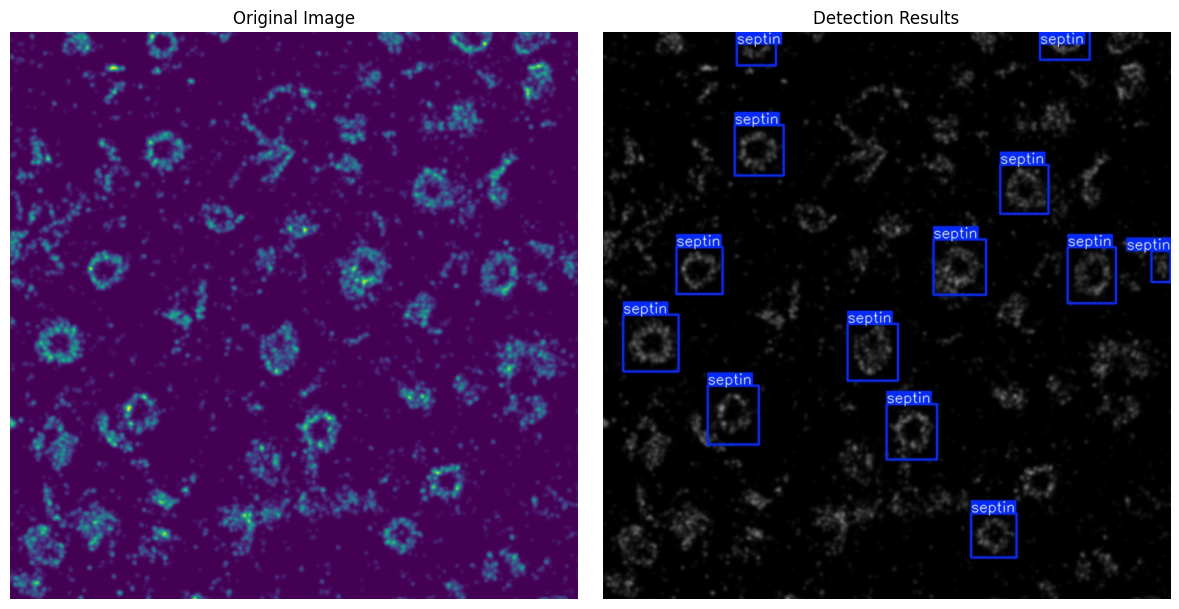

Progress:   0%|          | 0/1 [00:00<?, ?it/s]

*****************************************************************************************************
The prediction results are saved in --->  /content/Project_Septin/results/SeptinDetection_Model1_ep50 /
The center points are saved in --->  /content/Project_Septin/results/SeptinDetection_Model1_ep50/Centers /


In [18]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO  # Ensure YOLO is imported
# Specify your image dimensions, for example (200, 200)
image_shape = (patch_width, patch_height)

path_to_test_folder = '/content/Project_Septin/test'  # @param {type:"string"}
path_to_model = '/content/Project_Septin/datasets/runs/detect/train/weights/best.pt'  # @param {type:"string"}
path_to_results_folder = '/content/Project_Septin/results'  # @param {type:"string"}
resultsFolderName = trained_model_name
confidence = 0.2  # @param{type:"number"}
iou = 0.2  # @param{type:"number"}

path_to_centers = path_to_results_folder + '/' + resultsFolderName + '/Centers'
# Check if the output folder exists, if not, create it
if not os.path.exists(path_to_centers):
    os.makedirs(path_to_centers)

# Load YOLO model
model = YOLO(path_to_model)

# Function to draw centers on a binary image
def draw_centers_on_binary_image(boxes, image_shape):
    binary_image = np.zeros(image_shape, dtype=np.uint8)
    for box in boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0]
        center_x = int((x_min + x_max) / 2)
        center_y = int((y_min + y_max) / 2)
        binary_image[center_y - 1:center_y + 2, center_x - 1:center_x + 2] = 1
    return binary_image

# Verify the folder path
if not os.path.isdir(path_to_test_folder):
    print("The specified folder does not exist.")
else:
    print('Processing test images...')
    for image_file in tqdm(os.listdir(path_to_test_folder), desc='Progress'):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
            image_path = os.path.join(path_to_test_folder, image_file)

            # YOLO prediction
            results = model.predict(
                [image_path],
                conf=confidence,
                iou=iou,
                save=True,
                project=path_to_results_folder,
                name=resultsFolderName,
                exist_ok=True,
                show_conf=False,
                show_labels=True,
                save_crop=False,
                show_boxes=True,
                line_width=2
            )

            # Process the first result
            result = results[0]
            boxes = result.boxes  # Bounding box outputs

            # Create a binary image with centers marked
            binary_image = draw_centers_on_binary_image(boxes, image_shape)
            binary_image_pil = Image.fromarray(binary_image * 255)  # Multiply by 255 for white centers
            binary_image_pil.save(os.path.join(path_to_centers, f'centers_{image_file}.jpg'))

            # Load the original image and detection result for visualization
            original_image = Image.open(image_path)
            detection_image_path = os.path.join(path_to_results_folder, resultsFolderName, image_file)
            detection_image = Image.open(detection_image_path)

            # Display raw image and detection result side by side
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(original_image)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(detection_image)
            axs[1].set_title("Detection Results")
            axs[1].axis("off")

            plt.tight_layout()
            plt.show()
            break  # Stop after displaying the first result

print('*****************************************************************************************************')
print('The prediction results are saved in ---> ', os.path.join(path_to_results_folder, resultsFolderName), '/')
print('The center points are saved in ---> ', path_to_centers, '/')
